En este Notebook se van a extraer datos de las noticias financieras de 3 páginas importantes a nivel mundial y, ordenadas por fecha, se las va a comparar contra el índice S&P500. Así es, en lugar de analizar el sentimiento de cada noticia en base a un dataset de noticias pre-armado, vamos a comparar las noticias de cada fecha con el rendimiento que tuvo el S&P500 durante ese período y con ese valor vamos a asignarle una "puntuación" de sentimiento a la noticia. Con esos datos se armará el dataset que posteriormente vamos a usar para predecir el sentimiento de cada noticia y en consecuencia, el futuro precio del índice

In [91]:
# Importar librerías

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# Librerías de Selenium

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from time import sleep

In [5]:
# Scrolls

def _count_needed_scrolls(browser, infinite_scroll, numOfPost):
    if infinite_scroll:
        lenOfPage = browser.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;"
        )
    else:
        # roughly 8 post per scroll kindaOf
        lenOfPage = int(numOfPost / 8)
    return lenOfPage


def _scroll(browser, infinite_scroll, lenOfPage):
    lastCount = -1
    match = False

    while not match:
        if infinite_scroll:
            lastCount = lenOfPage
        else:
            lastCount += 1

        # wait for the browser to load, this time can be changed slightly ~3 seconds with no difference, but 5 seems
        # to be stable enough
        time.sleep(1)

        if infinite_scroll:
            lenOfPage = browser.execute_script(
                "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return "
                "lenOfPage;")
        else:
            browser.execute_script(
                "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return "
                "lenOfPage;")

        if lastCount == lenOfPage:
            match = True

In [6]:
# finance.yahoo.com

def scrape_yfinance(tag, numOfPost, infinite_scroll=False):
    news = {
        "titles" : [],
        "dates" : [],
        "par" : [],
        "font" : []
    }
    
    my_url = "https://finance.yahoo.com/quote/" + tag + "/news?p=" + tag
    option = Options()
    option.headless = False
    driver = webdriver.Chrome(options=option)
    driver.get(my_url)
    driver.maximize_window()
        
    # Length of page
    lenOfPage = _count_needed_scrolls(driver, infinite_scroll, numOfPost)
    _scroll(driver, infinite_scroll, lenOfPage)
    '''
    # Entrar en cada noticia
    for n in range(numOfPost):
        counter = 0
        while True:
            try:
                print(n)
                xpath = WebDriverWait(driver, 5).until(
                      EC.visibility_of_element_located((By.XPATH,
                      f"/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[5]/div/div/div/ul/li[{n+1}]/div/div/div[2]/h3/a")))
                href = xpath.get_attribute('href')
                driver.get(href)
                sleep(5)
                
                # Dentro de la noticia, obtener título, fecha y párrafo de interés

                # HTML
                html = BeautifulSoup(driver.page_source, 'html.parser')

                # Obtener título
                title = html.find(class_="caas-title-wrapper").h1.text
                news["titles"].append(title)
                
                # Obtener fecha
                date = html.find(class_="caas-attr-time-style").time.text
                news["dates"].append(date)

                # Obtener contenido
                content_list = []
                content = html.findAll("p")
                for p in content:
                    if tag in p.text:
                        content_list.append(p.text)
                    else:
                        continue
                news["par"].append(content_list)
                
                #Obtener fuente
                font = html.find(class_="caas-attr-provider").text
                news["font"].append(font)
                
                # Volver
                driver.back()
                break
                
            except:
                print(f'Failed to scrape {n}. Trying again in 5 seconds.')
                break      
    '''
    # Cerrar ventana
    driver.quit()
    
    # Return
    return news

In [34]:
# investing.com

def scrape_investing(tag, numOfPost, infinite_scroll=False):
    news = {
        "titles" : [],
        "dates" : [],
        "par" : [],
        "font" : [],
        "url" : []
    }

    my_url = "https://es.investing.com/search/?tab=news&q=" + tag
    option = Options()
    option.headless = False
    driver = webdriver.Chrome(options=option)
    driver.get(my_url)
    driver.maximize_window()
    
    # Length of page
    lenOfPage = _count_needed_scrolls(driver, infinite_scroll, numOfPost)
    _scroll(driver, infinite_scroll, numOfPost)
    
    # Entrar en cada noticia
    for n in range(numOfPost):
        
        counter = 0
        while True:

            try:
                print(n)
                xpath = WebDriverWait(driver, 2).until(
                      EC.visibility_of_element_located((By.XPATH,
                      f"/html/body/div[5]/section/div/div[4]/div[3]/div/div[{n+1}]/div/a")))
                href = xpath.get_attribute('href')

                #href = driver.find_element_by_xpath(f"/html/body/div[5]/section/div/div[4]/div[3]/div/div[{n+1}]/div/a").get_attribute('href')
                news['url'].append(href)
                driver.get(href)
                sleep(3)

                # Dentro de la noticia, obtener título, fecha y párrafo de interés

                # HTML
                html = BeautifulSoup(driver.page_source, 'html.parser')

                # Obtener título
                title = html.find(class_="articleHeader").text
                news["titles"].append(title)

                # Obtener fecha
                date = html.find(class_="contentSectionDetails").span.text
                news["dates"].append(date)

                # Obtener contenido
                content_list = []
                content = html.findAll("p")
                for p in content:
                    if tag in p.text:
                        content_list.append(p.text)
                    else:
                        continue
                news["par"].append(content_list)
                
                news['font'].append("Investing")

                # Volver
                driver.back()
                break
                
            except Exception as exception:
                if counter < 1:
                    print(exception.__class__.__name__)
                    counter += 1
                    sleep(1)
                    continue
                else:
                    break
                    
    
    # Cerrar ventana
    driver.quit()
    
    # Return
    return news

In [16]:
# Obteniendo las noticias

tag = "NASDAQ"
news = scrape_investing(tag, 200)
#news = scrape_yfinance("AAPL", 34)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
TimeoutException
Failed to scrape 27. Trying again in 1 seconds.
27
28
TimeoutException
Failed to scrape 28. Trying again in 1 seconds.
28
29
30
31
TimeoutException
Failed to scrape 31. Trying again in 1 seconds.
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
TimeoutException
Failed to scrape 48. Trying again in 1 seconds.
48
49
50
51
52
53
54
55
56
57
58
59
60
TimeoutException
Failed to scrape 60. Trying again in 1 seconds.
60
61
TimeoutException
Failed to scrape 61. Trying again in 1 seconds.
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
TimeoutException
Failed to scrape 77. Trying again in 1 seconds.
77
78
TimeoutException
Failed to scrape 78. Trying again in 1 seconds.
78
79
80
81
82
83
84
85
86
87
88
TimeoutException
Failed to scrape 88. Trying again in 1 seconds.
88
89
90
91
92
93
94
95
TimeoutException
Failed to scrape 95. Trying again in 1 seconds.
95
96
97
98
TimeoutException
Failed to scrape

In [70]:
# DataFrame

print(len(news['titles']))
print(len(news['dates']))
print(len(news['par']))
    
df = pd.DataFrame(news)

199
199
199


In [11]:
# Abrir dataframe desde archivo

#df = pd.read_excel("news.xlsx").drop("Unnamed: 0", axis=1)

In [71]:
# Corrijo las fechas (modificar para adaptar al modelo de fecha de Investig, tratar de captar también a las "Hace 6 horas")

for date in range(len(df['dates'])):
    index = str(df['dates'][date]).find("(")
    if index == -1:
        continue
    else:
        df['dates'][date] = df['dates'][date][index+1:-1]

df['dates'] = pd.to_datetime(df['dates'], format="%d.%m.%Y %M:%S", errors='coerce').dt.floor('d') #esto último quita H:M:S
df['dates'] = df['dates'].fillna(datetime.today())

df.to_excel("news.xlsx")

In [107]:
# Importo los precios

interval = '1d'
period= "max"
tiempo = 10

prices = yf.download(tickers="SPY", interval=interval, period=period)
prices = prices[['Open', 'High', 'Low', 'Close']] # VOlUMEN AGREGADO
prices["TMO-TDC"] = prices['Open'].shift(-1) / prices['Close'] - 1
prices["TMC-TDC"] = prices['Close'].shift(-1) / prices['Close'] - 1
prices

[*********************100%***********************]  1 of 1 completed


C:\Users\tomii\AppData\Local\Temp/ipykernel_8828/199094955.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices["TMO-TDC"] = prices['Open'].shift(-1) / prices['Close'] - 1


,Open,High,Low,Close,TMO-TDC,TMC-TDC
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,0.000711,0.007112
1993-02-01,43.968750,44.250000,43.968750,44.250000,-0.000706,0.002119
1993-02-02,44.218750,44.375000,44.125000,44.343750,0.001409,0.010571
1993-02-03,44.406250,44.843750,44.375000,44.812500,0.003487,0.004184
1993-02-04,44.968750,45.093750,44.468750,45.000000,-0.000694,-0.000694
...,...,...,...,...,...,...
2021-12-13,470.190002,470.559998,466.269989,466.570007,-0.007459,-0.006880
2021-12-14,463.089996,465.739990,460.250000,463.359985,0.000130,0.015625
2021-12-15,463.420013,470.859985,460.739990,470.600006,0.004186,-0.008819


In [108]:
# Asigno valores

prices_changes = prices[["TMO-TDC", "TMC-TDC"]].reset_index()
prices_changes.columns = ["dates", "TMO-TDC", "TMC-TDC"]

df = df.merge(prices_changes, on="dates", how="left")

In [75]:
from translate import translate

# Obtengo el array de textos

for n in range(len(df.par)):
    if len(df.par[n]) > 0:
        df.par[n] = df.par[n][0]
    else:
        df.par[n] = ""
translations = translate(df.par)

C:\Users\tomii\AppData\Local\Temp/ipykernel_8828/1683799143.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.par[n] = df.par[n][0]
C:\Users\tomii\AppData\Local\Temp/ipykernel_8828/1683799143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.par[n] = ""


AttributeError: 'dict' object has no attribute 'results'

In [82]:
# Dataset traducido

df['en'] = translations['to']

# Scores de sentimiento
from textblob import TextBlob

scores = []
for text in df.en:
    scores.append(TextBlob(text).sentiment.polarity)
    
df['scores'] = scores

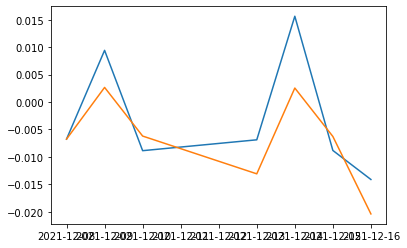

In [114]:
# Score final

df['final_score'] = (df['TMO-TDC'] + df['TMC-TDC'] + df.scores) / 3

var = "TMC-TDC"

pivot = pd.pivot_table(df, values=var, index="dates", aggfunc=np.mean)
pivot['cum_score'] = np.cumsum(pivot[var]) 
plt.plot(pivot)
